In [22]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Pipeline imports
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,FunctionTransformer
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV



In [23]:
from typing import Literal
from sklearn.base import BaseEstimator

def BMI(weight, height):
    return weight/(height**2/(100*100))

class CustomTransformer(BaseEstimator, TransformerMixin):
    """
    Transofrmer which imputes Obesity and Polydipsia parametrically with BMI and Urination
    """
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        """Expected method by the pipeline API"""
        return self

    def transform(self, X, y=None, threshold_BMI=30, threshold_Polydipsia= 2.5):
        X = self._BMI(X, threshold=threshold_BMI)
        X = self._fix_polydipsia(X, threshold=threshold_Polydipsia)
        return X
    
    def _BMI(self, X, y=None, threshold=30):
        # Perform arbitary transformation
        idx = X[X['Obesity'].isna()].index
        
        # indexes to identify BMI above or below threshold
        idx2 = X.loc[idx,].loc[BMI(X.loc[idx,]["Weight"], X.loc[idx,]["Height"]) <= threshold].index
        idx3 = X.loc[idx,].loc[BMI(X.loc[idx,]["Weight"], X.loc[idx,]["Height"]) > threshold].index
        
        # set obesity from indexes above
        X.loc[idx2,'Obesity'] = 0
        X.loc[idx3,'Obesity'] = 1
        return X
    
    def _fix_polydipsia(self, df, threshold=2.5):
        idx = df[df['Polydipsia'].isna()].index
        
        # indexes to identify Urination above or below threshold
        idx2 = df.loc[idx,].loc[df['Urination'] <= threshold].index
        idx3 = df.loc[idx,].loc[df['Urination'] > threshold].index

        # set Polydipsia from indexes above
        df.loc[idx2,'Polydipsia'] = 0
        df.loc[idx3,'Polydipsia'] = 1
        #df.loc[idx,]
        return df
    
    def set_output(self, *, transform: Literal['default', 'pandas'] | None = None) -> BaseEstimator:
        return super().set_output(transform=transform)


class AddBMI(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        """Expected method by the pipeline API"""
        return self

    def transform(self, X, y=None):
        X['BMI'] = BMI(X['Weight'], X['Height'])
        return X
    
    def set_output(self, *, transform: Literal['default', 'pandas'] | None = None) -> BaseEstimator:
        return super().set_output(transform=transform)

class Outliers(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        """Expected method by the pipeline API"""
        return self

    def transform(self, X: pd.DataFrame, y=None):
        df = X[self.features].copy()
        mask = abs((df - df.mean())/df.std()) > 3 # Standardize
        X[mask] = np.NaN
        return X
    
    def get_feature_names_out(self, *args, **params):
        """
        method which enables pass through of column names, preserving them in the final transformed data frame
        """
        return self.columns_


# Read data

I chose to read data directly for ease of testing

In [24]:

diabetes = pd.read_csv('diabetes.csv')
binary_features = ['Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness',
                'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching',
                'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia', 'Gender']
cat_features = ['Race',	'Occupation',	'GP']
num_features = ['Age',	'Height',	'Weight',	'Temperature',	'Urination']


target = 'Diabetes'
y = diabetes[target]
X = diabetes.drop(columns=(target))
# y = y.replace({'Positive':1, 'Negative':0}) # again, format on original data set



# Some helpers

In [25]:
def fix_height(x, threshold=100):
    """ Converts height in meters to centimeters, if height is less than threshold (default = 100)"""
    col = x.columns[0]
    mask = x[col] < threshold
    x.loc[mask, [col]] = x.loc[mask, [col]].mul(100)
    return x

def fix_formating(x):
    return x.replace({'yes':1, 'Yes': 1, 'Positive':1, 'no':0, 'No':0, 'Negative':0, 'Male':1,'Female':0})


## $\epsilon$ privacy

# Constructing Pipeline

I compose the pipeline from smaller pipelines, which all handles a subset of the tasks.

The numeric, binary and categorical columns are all handled differently. 
In addition, construct a parametric preprocessor where we can impute with domain knowledge. We must adapt the functions from the other script to do so, and I have only done that to a few easy ones.

For transformations which rely on other columns, like fixing obesity and polydipsia, we must use a slightly more complicated approach with classes, which I haven't attempted yet.

Row wise transformations, like outliers, must also be implemented, and I have not looked at that either.

In [26]:
# Parametric preprocessor where we impute with domain knowledge
preprocessor_parametric = ColumnTransformer(
    transformers=[
        # ('fix height', FunctionTransformer(fix_height), ['Height']),
    ],
    verbose_feature_names_out= False, # Keeps the same column name for future processing
    remainder='passthrough'         # Doesent drop untransformed columns
).set_output(transform='pandas')    # Keep data frame format

binary_transformer = Pipeline(
    steps=[
        ('Fix formating', FunctionTransformer(fix_formating)),
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        # ('randomize', FunctionTransformer(randomize)), # privacy has been moved to a separate pipeline
        # ("selector", SelectKBest(k=5)),
    ]
)

cat_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=0.1, sparse=False)),
        # Unsure how to introduce privacy,
        # ("selector", SelectKBest(k=5)),
    ]
)

num_transformer = Pipeline(
    steps=[
           # Differential privacy here
           # Outliers Here
            ('Outliers', Outliers(num_features)), 
            ("imputer", SimpleImputer(strategy="mean")), 
            ("scaler", StandardScaler())]
)


# General preprocesser which encodes and scales all features
preprocessor_general = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
        ('binary', binary_transformer, binary_features)
    ],
    verbose_feature_names_out= True,
    remainder='drop'                # drop untouched features since after this step, as it is the last preprocessing one
).set_output(transform="pandas")    # Keep data frame format


preprocessor = Pipeline(
    steps=[
        ('Custom impute', CustomTransformer()),
        # ('Add columns', AddBMI()),
        ("preprocessor parametric", preprocessor_parametric), 
        ("preprocessor general", preprocessor_general), 
        ]
)


clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ("classifier", tree.DecisionTreeClassifier())
        ]
)


def make_clf(clf):
    return Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ("classifier", clf)
        ]
    )

clf # Displays the pipeline


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('Custom impute', CustomTransformer()),
                                 ('preprocessor parametric',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[],
                                                    verbose_feature_names_out=False)),
                                 ('preprocessor general',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('Outliers',
                                                                                    Outliers(features=['Age',
                                                                                                       'Height',
                                                                                                       'Weight',
                                                                                                       'Temperature',...
                                                                                    FunctionTransformer(func=<function fix_formating at 0x14d495440>)),
                                                                                   ('imputer',
                                                                                    SimpleImputer(fill_value=0,
                                                                                                  strategy='constant'))]),
                                                                   ['Obesity',
                                                                    'TCep',
                                                                    'Polydipsia',
                                                                    'Sudden '
                                                                    'Weight '
                                                                    'Loss',
                                                                    'Weakness',
                                                                    'Polyphagia',
                                                                    'Genital '
                                                                    'Thrush',
                                                                    'Visual '
                                                                    'Blurring',
                                                                    'Itching',
                                                                    'Irritability',
                                                                    'Delayed '
                                                                    'Healing',
                                                                    'Partial '
                                                                    'Paresis',
                                                                    'Muscle '
                                                                    'Stiffness',
                                                                    'Alopecia',
                                                                    'Gender'])]))])),
                ('classifier', DecisionTreeClassifier())])

# Running pipeline
## Predicting


In [27]:

X_train, X_test, y_train, y_test = train_test_split(X, y) # Simple train-test spliot

clf.fit(X_train, y_train)
print("Train score: %.3f" % clf.score(X_train, y_train))
#print("Test score: %.3f" % clf.score(X_test, y_test))

Train score: 1.000


## Transformed data frame

Allows inspection into the final preprocessed data frame which the prediction model trains on

In [28]:
display(preprocessor.fit_transform(X_train, y_train))


,num__Age,num__Height,num__Weight,num__Temperature,num__Urination,cat__Race_White,cat__Race_infrequent_sklearn,cat__Occupation_Retired,cat__Occupation_infrequent_sklearn,cat__GP_infrequent_sklearn,...,binary__Polyphagia,binary__Genital Thrush,binary__Visual Blurring,binary__Itching,binary__Irritability,binary__Delayed Healing,binary__Partial Paresis,binary__Muscle Stiffness,binary__Alopecia,binary__Gender
117,0.833382,1.357075e+00,0.132671,-0.564944,-2.012929,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
415,-0.243269,2.852143e-15,0.936611,0.913279,1.167679,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
269,1.578755,-3.037312e-01,1.564994,0.807692,0.000000,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
143,-0.160449,1.433342e+00,-0.434816,-0.353770,-1.352803,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
507,-0.988642,5.984229e-01,1.081722,0.913279,-1.247783,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,-0.408907,-8.095230e-02,-0.901892,0.279755,-0.332608,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
241,0.502105,2.140792e-01,-0.466559,1.810773,-1.097754,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
324,1.578755,4.107669e-01,2.129242,1.810773,0.837616,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
466,-1.651196,-5.104539e-01,-0.122569,0.279755,-0.917720,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [29]:
for depth in range(1,20):
    scores = cross_val_score(make_clf(tree.DecisionTreeClassifier(max_depth=depth)), X_train, y_train, cv=5)
    print(f"depth: {depth}, cv score: {np.mean(scores):.3f}")


depth: 1, cv score: 0.777
depth: 2, cv score: 0.824
depth: 3, cv score: 0.875
depth: 4, cv score: 0.890
depth: 5, cv score: 0.878
depth: 6, cv score: 0.885
depth: 7, cv score: 0.883
depth: 8, cv score: 0.895
depth: 9, cv score: 0.892
depth: 10, cv score: 0.875
depth: 11, cv score: 0.870
depth: 12, cv score: 0.885
depth: 13, cv score: 0.890
depth: 14, cv score: 0.880
depth: 15, cv score: 0.890
depth: 16, cv score: 0.875
depth: 17, cv score: 0.880
depth: 18, cv score: 0.900
depth: 19, cv score: 0.883


## Cross validation for parameter tuning

I implemented a grid search of the parameter space (currently only the max depth, but it can easily be expanded).

In [30]:

param_grid = {
    # 'classifier__max_depth' : range(1, 15),
    # 'classifier__min_impurity_decrease' : np.linspace(0,1,10),
    'classifier__ccp_alpha' : np.linspace(0,1,10),
}

def tune_clf(clf, X_train, y_train, param_grid=param_grid):
    """
    Tunes a model with a grid search of the parameter space, then returns a model trained on the optimal hyperparameters.

    ----
    returns:
    {
        'model',
        'train score'
    }
    """
    model = GridSearchCV(clf, param_grid=param_grid).fit(X_train, y_train)
    best_model = model.best_estimator_.fit(X_train, y_train)
    # print(best_model['classifier'].max_depth)
    return {'model': best_model, 'train score': best_model.score(X_train, y_train)}


In [31]:
model = tune_clf(make_clf(tree.DecisionTreeClassifier()), X_train, y_train)['model']


### Evaluating multiple metrics



In [32]:
from sklearn.metrics import confusion_matrix 

def score(model, X, y):
    """
    Accepts a model (implementing a .predict method) and some data, X, with labels y, 
    and returns the accuracy, precision, recall and F1 score.

    Warning: the lenght of the return value is assumed to be equal to the lenght of the socre names
    """
    y_hat = model.predict(X)
    cm = confusion_matrix(y, y_hat)
    acc = (cm[0,0] + cm[1,1])/(np.sum(cm))
    prec = (cm[1,1])/(cm[1,1] + cm[0,1])
    rec = (cm[1,1])/(cm[1,1] + cm[1,0])
    f1 = 2*prec*rec/(prec+rec)


    return acc, prec, rec, f1

score_names = ['accuracy', 'precision', 'recall', 'F1']

score(model, X_test, y_test)




(0.927007299270073, 0.9310344827586207, 0.9529411764705882, 0.941860465116279)

### Some bootstrapping

In [33]:
n_samples = 200

train_scores = np.zeros(shape=(n_samples, len(score_names)))
test_scores = np.zeros_like(train_scores)

for i in range(n_samples):
    print(f'{i/n_samples:.2f}')
    X_train, X_test, y_train, y_test = train_test_split(X, y) # Simple train-test spliot

    model =  tune_clf(make_clf(tree.DecisionTreeClassifier()), X_train, y_train)['model']
    train_scores[i] = score(model, X_train, y_train)
    test_scores[i] = score(model, X_test, y_test)

train_scores = pd.DataFrame(train_scores,columns=score_names)
test_scores = pd.DataFrame(test_scores,columns=score_names)

0.00
0.01
0.01
0.01
0.02
0.03
0.03
0.04
0.04
0.04
0.05
0.06
0.06
0.07
0.07
0.07
0.08
0.09
0.09
0.10
0.10
0.10
0.11
0.12
0.12
0.12
0.13
0.14
0.14
0.14
0.15
0.15
0.16
0.17
0.17
0.17
0.18
0.18
0.19
0.20
0.20
0.20
0.21
0.21
0.22
0.23
0.23
0.23
0.24
0.24
0.25
0.26
0.26
0.27
0.27
0.28
0.28
0.28
0.29
0.29
0.30
0.30
0.31
0.32
0.32
0.33
0.33
0.34
0.34
0.34
0.35
0.35
0.36
0.36
0.37
0.38
0.38
0.39
0.39
0.40
0.40
0.41
0.41
0.41
0.42
0.42
0.43
0.43
0.44
0.45
0.45
0.46
0.46
0.47
0.47
0.47
0.48
0.48
0.49
0.49
0.50
0.51
0.51
0.52
0.52
0.53
0.53
0.54
0.54
0.55
0.55
0.56
0.56
0.56
0.57
0.57
0.58
0.58
0.59
0.59
0.60
0.60
0.61
0.61
0.62
0.62
0.63
0.64
0.64
0.65
0.65
0.66
0.66
0.67
0.67
0.68
0.68
0.69
0.69
0.69
0.70
0.70
0.71
0.71
0.72
0.72
0.73
0.73
0.74
0.74
0.75
0.76
0.76
0.77
0.77
0.78
0.78
0.79
0.79
0.80
0.80
0.81
0.81
0.81
0.82
0.82
0.83
0.83
0.84
0.84
0.85
0.85
0.86
0.86
0.87
0.88
0.88
0.89
0.89
0.90
0.90
0.91
0.91
0.92
0.92
0.93
0.93
0.94
0.94
0.94
0.95
0.95
0.96
0.96
0.97
0.97
0.98
0.98
0.99
0.99


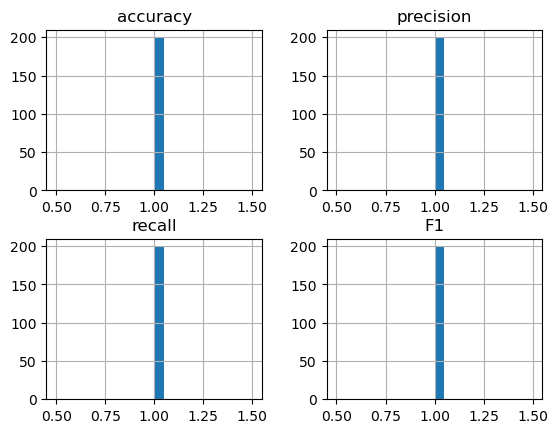

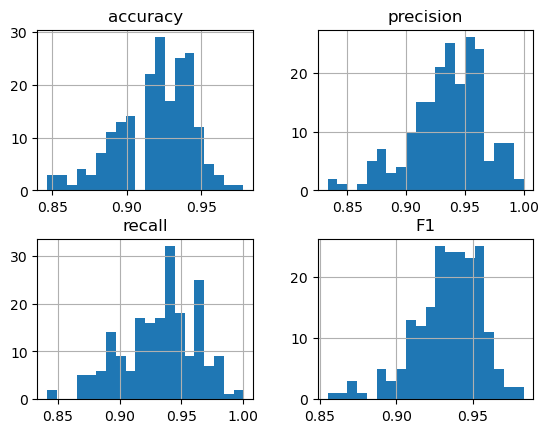

In [34]:
train_scores.hist(bins=n_samples//10)
test_scores.hist(bins=n_samples//10)
None # hides ugly last line